# Setup

In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import learning_curve

In [2]:
# Download latest version
path = kagglehub.dataset_download("muhammadshahidazeem/customer-churn-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'customer-churn-dataset' dataset.
Path to dataset files: /kaggle/input/customer-churn-dataset


In [3]:
df = pd.read_csv('/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv')
df.shape

(440833, 12)

# Data understanding

## Data profiling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [5]:
df.isna().all(axis=1).sum()


np.int64(1)

In [6]:
df[df.isna().all(axis=1)]


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = df.dropna(how="all")
df.shape

(440832, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 43.7+ MB


In [9]:
# 1. Check total missing values
df.isna().sum()

# 2. Check categorical uniques
for col in ['Gender', 'Subscription Type', 'Contract Length']:
    print(col, df[col].unique())

# 3. Check numeric NaNs
df.select_dtypes(include=['float64', 'int64']).isna().sum()


Gender ['Female' 'Male']
Subscription Type ['Standard' 'Basic' 'Premium']
Contract Length ['Annual' 'Monthly' 'Quarterly']


,0
CustomerID,0
Age,0
Tenure,0
Usage Frequency,0
Support Calls,0
Payment Delay,0
Total Spend,0
Last Interaction,0
Churn,0


Inspection of the dataset revealed a single row containing only missing values, which caused NaNs to appear in categorical and numerical features despite most columns showing full non-null counts. This fully empty row was removed to ensure data consistency before preprocessing and modeling.

## Feature semantics

###Context

This dataset contains customer profiles for a subscription/service business and a target label Churn (whether a customer stopped using/buying the service). The goal is to understand which factors correlate with churn and to build a model that can predict churn from customer demographics, usage, support behavior, and subscription/contract details.


###Content

* CustomerID: Unique identifier for each customer record.
* Age: Customer’s age (numeric).
* Gender: Customer’s gender (e.g., Female, Male).
* Tenure: How long the customer has been with the company.
* Usage Frequency: How frequently the customer uses the product/service over a period (numeric usage rate).
* Support Calls: Number of support/customer service calls made by the customer (count).
* Payment Delay: Payment delay amount (numeric; e.g., days late / delay level, depending on your preprocessing assumptions).
* Subscription Type: Type/tier of subscription plan (categorical; e.g., Basic, Standard, etc.).
* Contract Length: Contract duration category (categorical; e.g., Monthly, Annual).
* Total Spend: Total amount spent by the customer over the observed period (numeric).
* Last Interaction: Recency of the customer’s last interaction/activity (numeric; commonly treated as “days since last interaction”).
* Churn: Target label indicating whether the customer churned

###Data distribution

In [10]:
df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [11]:
df.sample(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
302275,309389.0,21.0,Male,58.0,1.0,1.0,1.0,Standard,Quarterly,676.03,23.0,0.0
25565,25574.0,39.0,Male,8.0,20.0,6.0,20.0,Standard,Quarterly,769.00,10.0,1.0
330533,337648.0,31.0,Male,5.0,8.0,1.0,20.0,Premium,Annual,718.17,11.0,0.0
46041,46656.0,29.0,Female,36.0,4.0,1.0,5.0,Premium,Quarterly,992.00,29.0,1.0
211050,216337.0,23.0,Male,47.0,18.0,2.0,30.0,Premium,Annual,641.14,6.0,1.0


# Data preprocessing: Drop the unnecessary columns


There are some features that we can drop, as they are not relevant for the goal:
* CustomerID  

In [12]:
df = df.drop(['CustomerID'], axis=1)

# Data preprocessing: Visualization

Let's first see what categorical values we have.

In [13]:
print(df.select_dtypes(include='object').nunique())

Gender               2
Subscription Type    3
Contract Length      3
dtype: int64


In [14]:
categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']
for col in categorical_cols:
  print(f"{col}: {df[col].unique()}")

Gender: ['Female' 'Male']
Subscription Type: ['Standard' 'Basic' 'Premium']
Contract Length: ['Annual' 'Monthly' 'Quarterly']


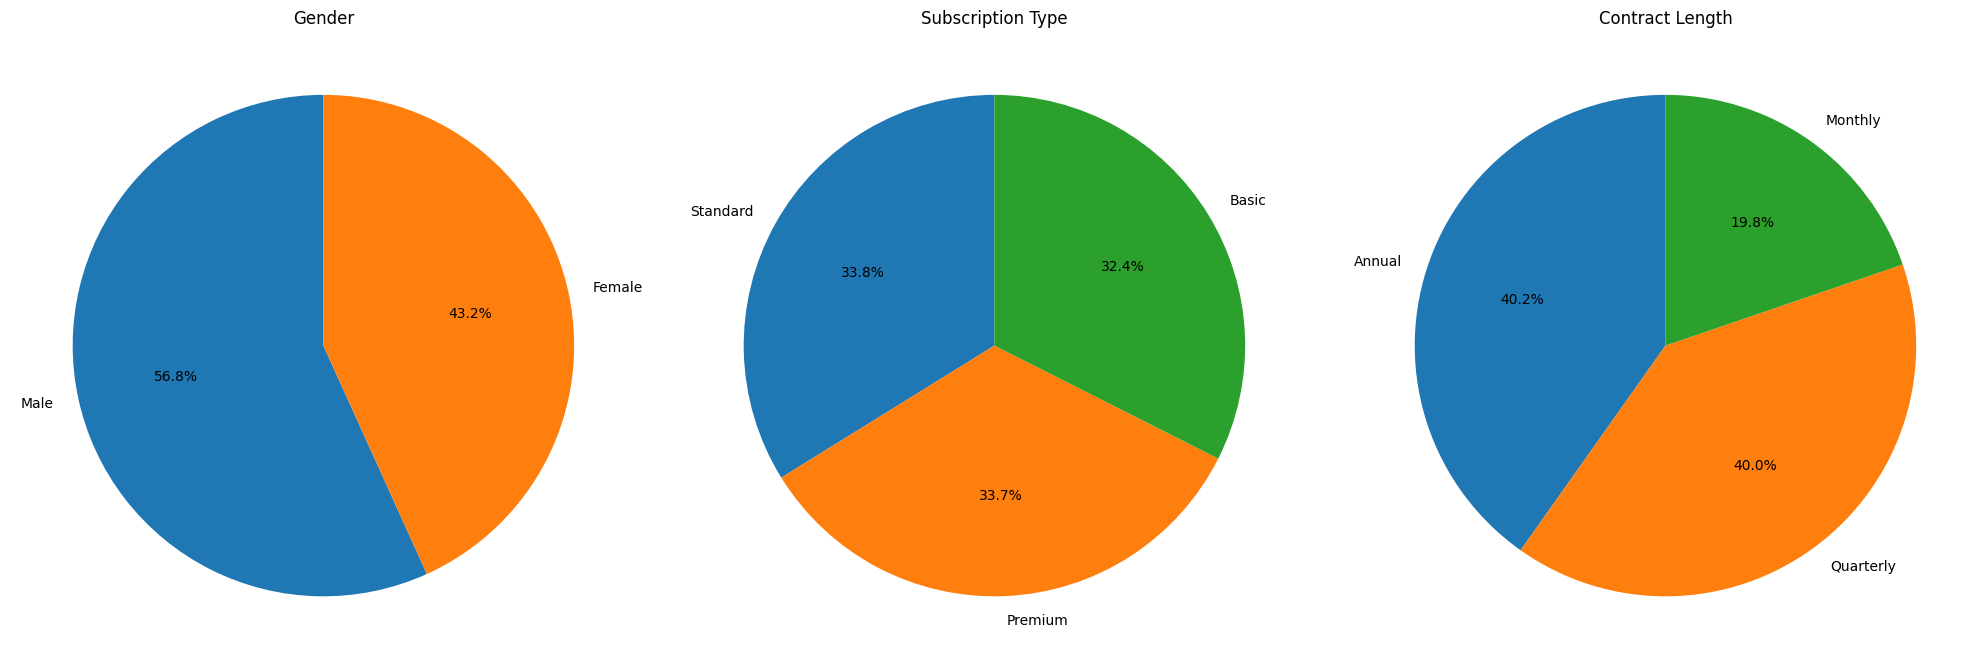

In [15]:
cols = ['Gender', 'Subscription Type', 'Contract Length']
fig, axes = plt.subplots(1, 3, figsize=(20, 20))

for i, col in enumerate(cols):
  df[col].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', ax=axes[i], startangle=90)
  axes[i].set_title(col)
  axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [16]:
df['Churn'].value_counts(normalize=True)

,proportion
Churn,
1.0,0.567107
0.0,0.432893


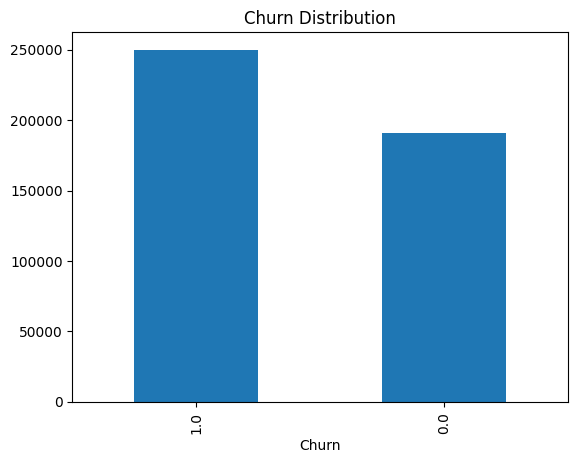

In [17]:
df['Churn'].value_counts().plot(kind='bar')
plt.title("Churn Distribution")
plt.show()


The churn label shows a relatively balanced distribution, with approximately 56.7% churned and 43.3% non-churned customers. Since neither class is underrepresented, no class imbalance handling or resampling techniques are required. Standard classification metrics such as ROC-AUC, precision, recall, and F1-score are therefore appropriate for model evaluation.

# Checking correlations

<Axes: >

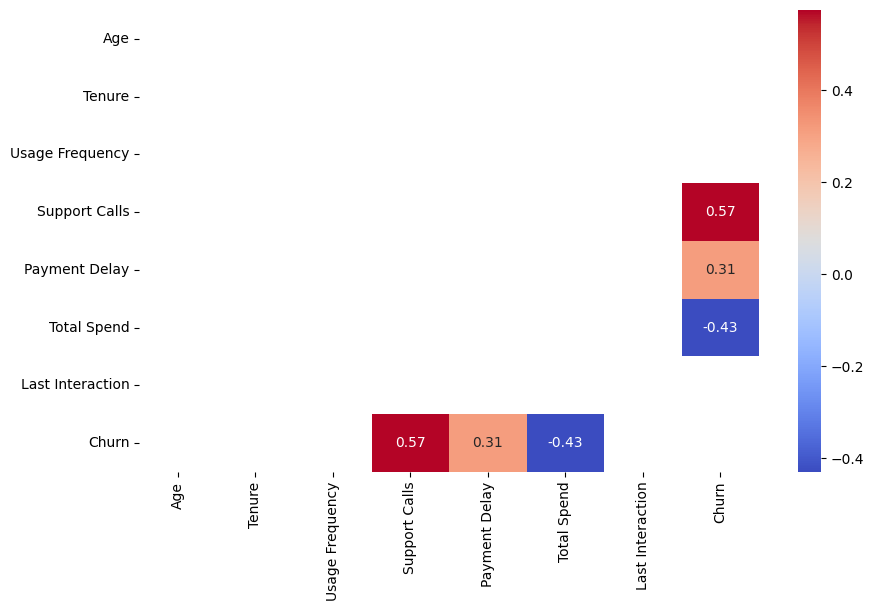

In [18]:
correlation_mat = df.corr(method='pearson', numeric_only=True)
min_corr = 0.3
filtered_corr = correlation_mat[(abs(correlation_mat) >= min_corr) & (correlation_mat < 1)]

plt.figure(figsize=(10,6))
sns.heatmap(filtered_corr, cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)


The correlation analysis reveals strong relationships between churn and several behavioral features. Support Calls show a strong positive correlation with churn, indicating that frequent customer support interactions are associated with a higher likelihood of churn. Payment Delay is moderately positively correlated with churn, while Total Spend exhibits a moderate negative correlation, suggesting that higher-value customers are less likely to churn. No strong correlations are observed among predictor variables themselves, indicating the absence of multicollinearity and confirming that all features can be retained for modeling.

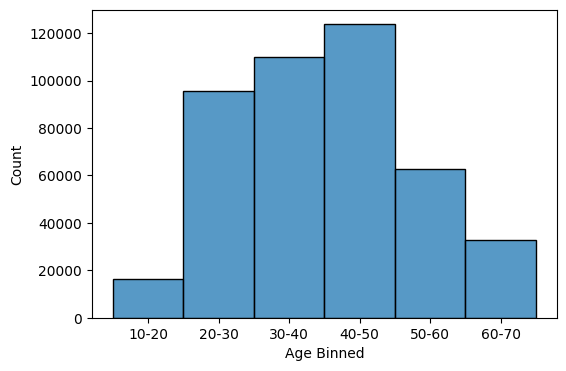

In [19]:
age_bins = range(0, 101, 10)
age_labels = [f'{i}-{i+10}' for i in age_bins[:-1]]

df['Age Binned'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='Age Binned')
plt.show()

The age distribution shows that most customers fall within the 20–60 age range, with the highest concentration between 30–50 years. Younger (below 20) and older (above 60) customers are less represented in the dataset. This suggests that the customer base is primarily composed of working-age individuals, which may influence usage patterns and churn behavior.

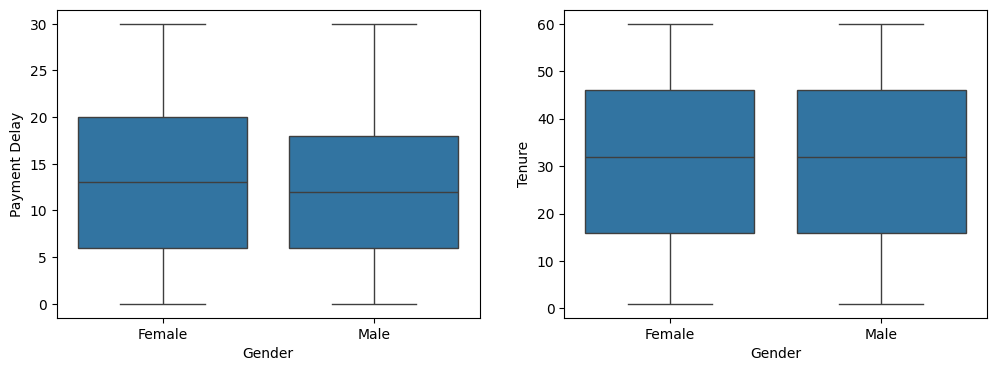

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(x = "Gender", y = "Payment Delay", data = df, ax=axes[0])
sns.boxplot(x = 'Gender', y = "Tenure", data = df, ax=axes[1])
plt.show()

The boxplots show that Payment Delay and Tenure distributions are broadly similar across genders. Both female and male customers exhibit comparable medians and interquartile ranges, indicating no strong gender-based differences in payment behavior or customer longevity. Minor variations are visible, but overall gender does not appear to be a dominant factor influencing payment delays or tenure in this dataset.

# Data preprocessing: Encoding

In [21]:
df['Gender'] = df['Gender'].map({'Female': True, 'Male': False})

Encode Gender into boolean values.

In [22]:
df = pd.get_dummies(
    df,
    columns=['Subscription Type', 'Contract Length'],
    drop_first=True)

After applying one-hot encoding with get_dummies(drop_first=True), categorical features with three categories are represented by two binary columns, while the omitted category acts as a reference group. This approach avoids multicollinearity and preserves all information. The resulting boolean and numeric features are suitable for model training.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Age                         440832 non-null  float64 
 1   Gender                      440832 non-null  bool    
 2   Tenure                      440832 non-null  float64 
 3   Usage Frequency             440832 non-null  float64 
 4   Support Calls               440832 non-null  float64 
 5   Payment Delay               440832 non-null  float64 
 6   Total Spend                 440832 non-null  float64 
 7   Last Interaction            440832 non-null  float64 
 8   Churn                       440832 non-null  float64 
 9   Age Binned                  440832 non-null  category
 10  Subscription Type_Premium   440832 non-null  bool    
 11  Subscription Type_Standard  440832 non-null  bool    
 12  Contract Length_Monthly     440832 non-null  bool    
 13  Cont

# Train-Test split

In [24]:
x= df.drop(['Age Binned', 'Churn'], axis=1)
y= df['Churn']

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [26]:
feature_names = x_train.columns

# Scaling with StandardScaler

In [27]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [28]:
x_train = pd.DataFrame(x_train, columns=feature_names)
x_test = pd.DataFrame(x_test, columns=feature_names)

In [29]:
x_train.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,-1.234718,-0.872308,1.550094,1.419341,-1.173301,-1.086163,0.139639,1.689759,-0.713844,-0.714093,-0.495818,-0.818751
1,-1.234718,-0.872308,-0.305269,-0.443767,-0.847672,1.578104,0.508215,-0.287785,-0.713844,-0.714093,-0.495818,1.221373
2,-1.716941,-0.872308,0.274532,-0.909544,-1.173301,-0.722854,0.918640,-0.636763,1.400866,-0.714093,-0.495818,1.221373
3,-0.270271,1.146384,-0.769110,-0.793100,-0.522042,1.214794,0.524821,-1.334720,1.400866,-0.714093,2.016867,-0.818751
4,1.417510,1.146384,-0.247289,1.186452,1.431737,0.245970,0.234211,-0.520437,-0.713844,-0.714093,2.016867,-0.818751


StandardScaler performs feature-wise normalization by scaling each column independently. After scaling, each feature has approximately zero mean and unit standard deviation. As a result, most values fall roughly within the range −3 to +3, although there is no fixed minimum or maximum. The scaler is fit only on the training set and then applied to the test set to avoid data leakage.

# Classification

## Random Forest

In [30]:
# Define the base model
rf = RandomForestClassifier(random_state=42,n_jobs=-1)

# Define the hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Randomized Search CV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=2,
    n_jobs=-1
)


In [31]:
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='accuracy', verbose=2)

In [32]:
# Best model
best_rf = rf_random.best_estimator_

print("Best Parameters:")
print(rf_random.best_params_)

Best Parameters:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}


In [33]:
# Predictions
rf_pred = best_rf.predict(x_test)
rf_proba   = best_rf.predict_proba(x_test)[:, 1]

In [34]:
# Evaluation
print("\nAccuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_proba))


Accuracy: 0.9997618156453094

Classification Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38063
         1.0       1.00      1.00      1.00     50104

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167

ROC-AUC: 0.9999996607429612


### Overfitting Check

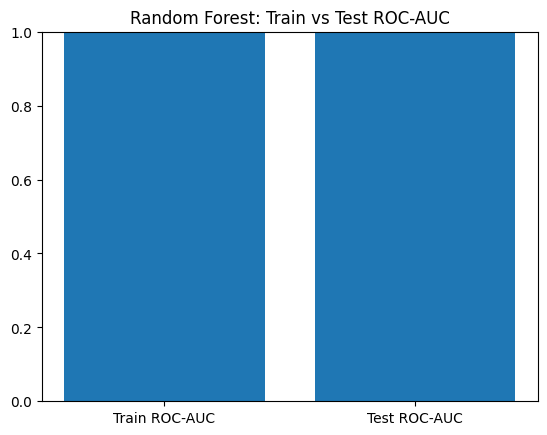

In [35]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

rf_train_proba = best_rf.predict_proba(x_train)[:, 1]
rf_test_proba  = best_rf.predict_proba(x_test)[:, 1]

scores_rf = {
    "Train ROC-AUC": roc_auc_score(y_train, rf_train_proba),
    "Test ROC-AUC": roc_auc_score(y_test, rf_test_proba)
}

plt.figure()
plt.bar(scores_rf.keys(), scores_rf.values())
plt.ylim(0, 1)
plt.title("Random Forest: Train vs Test ROC-AUC")
plt.show()


## Xgboost

In [36]:
# XGBoost classifier (binary churn)
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

# Hyperparameter search space
param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5, 7],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.5],
    "reg_alpha": [0, 0.01, 0.1, 1.0],
    "reg_lambda": [1.0, 1.5, 2.0]
}

# Randomized Search CV
xgb_random = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


In [37]:
# Fit
xgb_random.fit(x_train, y_train)

best_xgb = xgb_random.best_estimator_
print("Best Parameters:\n", xgb_random.best_params_)




Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters:
 {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8}


In [38]:
# Predict
xgb_pred = best_xgb.predict(x_test)
xgb_proba = best_xgb.predict_proba(x_test)[:, 1]

In [39]:
# Evaluate
print("\nAccuracy:", accuracy_score(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_proba))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred))


Accuracy: 0.9998525525423344
ROC-AUC: 0.9999994043338546

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38063
         1.0       1.00      1.00      1.00     50104

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



### Overfitting Check

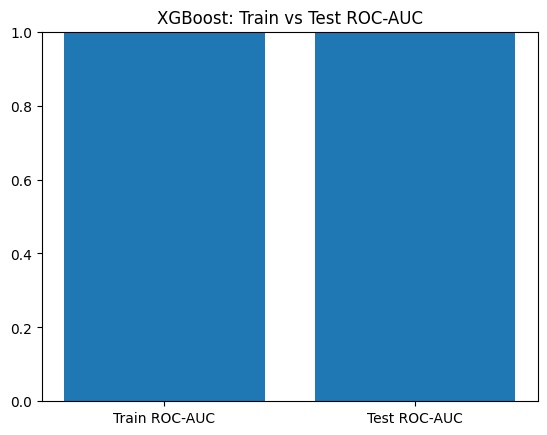

In [40]:
xgb_train_proba = best_xgb.predict_proba(x_train)[:, 1]
xgb_test_proba  = best_xgb.predict_proba(x_test)[:, 1]

scores_xgb = {
    "Train ROC-AUC": roc_auc_score(y_train, xgb_train_proba),
    "Test ROC-AUC": roc_auc_score(y_test, xgb_test_proba)
}

plt.figure()
plt.bar(scores_xgb.keys(), scores_xgb.values())
plt.ylim(0, 1)
plt.title("XGBoost: Train vs Test ROC-AUC")
plt.show()


## Lightgbm

In [41]:
# LightGBM classifier (binary churn)
lgbm_clf = lgb.LGBMClassifier(
    objective="binary",
    n_jobs=-1,
    random_state=42
)

# Hyperparameter search space
param_dist = {
    "n_estimators": [300, 500, 800, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "num_leaves": [15, 31, 63, 127],
    "max_depth": [-1, 4, 6, 8, 12],
    "min_child_samples": [10, 20, 30, 50, 100],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0.0, 0.01, 0.1, 1.0],
    "reg_lambda": [0.0, 0.1, 1.0, 2.0]
}

# Randomized Search CV
lgbm_random = RandomizedSearchCV(
    estimator=lgbm_clf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


In [42]:
# Fit
lgbm_random.fit(x_train, y_train)

best_lgbm = lgbm_random.best_estimator_
print("Best Parameters:\n", lgbm_random.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199895, number of negative: 152770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 486
[LightGBM] [Info] Number of data points in the train set: 352665, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566813 -> initscore=0.268859
[LightGBM] [Info] Start training from score 0.268859
Best Parameters:
 {'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 20, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [43]:
# Predict
lgbm_pred = best_lgbm.predict(x_test)
lgbm_proba = best_lgbm.predict_proba(x_test)[:, 1]

In [44]:
# Evaluate
print("\nAccuracy:", accuracy_score(y_test, lgbm_pred))
print("ROC-AUC:", roc_auc_score(y_test, lgbm_proba))
print("\nClassification Report:\n", classification_report(y_test, lgbm_pred))


Accuracy: 0.9998298683180782
ROC-AUC: 0.9999996072588532

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38063
         1.0       1.00      1.00      1.00     50104

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



### Overfitting Check

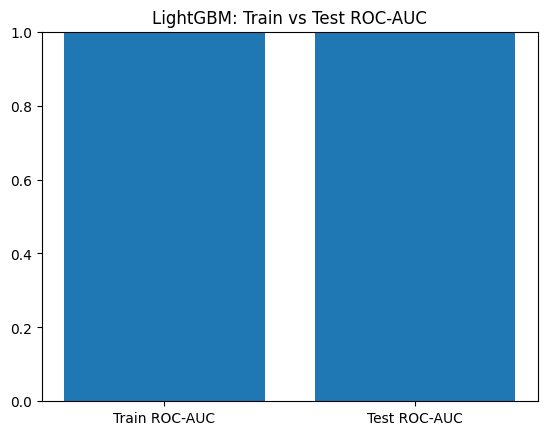

In [45]:
lgbm_train_proba = best_lgbm.predict_proba(x_train)[:, 1]
lgbm_test_proba  = best_lgbm.predict_proba(x_test)[:, 1]

scores_lgbm = {
    "Train ROC-AUC": roc_auc_score(y_train, lgbm_train_proba),
    "Test ROC-AUC": roc_auc_score(y_test, lgbm_test_proba)
}

plt.figure()
plt.bar(scores_lgbm.keys(), scores_lgbm.values())
plt.ylim(0, 1)
plt.title("LightGBM: Train vs Test ROC-AUC")
plt.show()


# Comparison

In [46]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix)

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Random Forest,0.999762,0.99996,0.999621,0.99979,1.000000
1,XGBoost,0.999853,1.00000,0.999741,0.99987,0.999999
2,LightGBM,0.999830,0.99996,0.999741,0.99985,1.000000


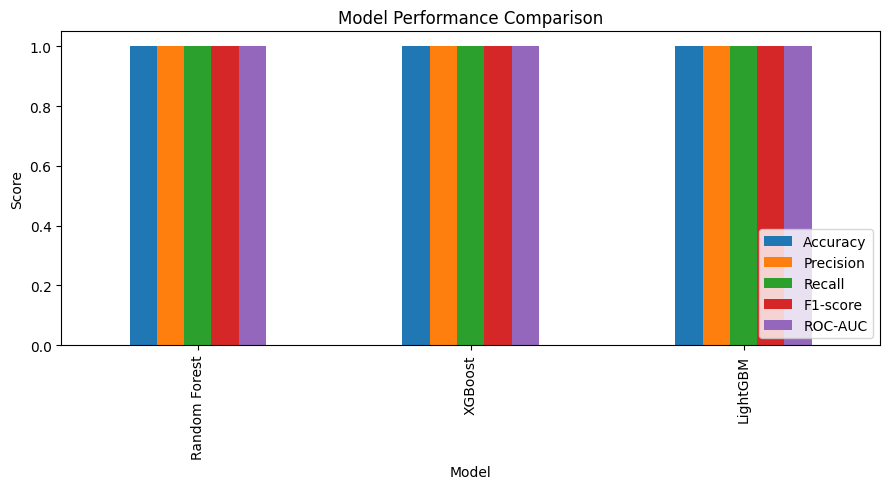

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, RocCurveDisplay
)

# ---- Comparison table ----
results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "LightGBM"],
    "Accuracy": [
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, xgb_pred),
        accuracy_score(y_test, lgbm_pred)
    ],
    "Precision": [
        precision_score(y_test, rf_pred),
        precision_score(y_test, xgb_pred),
        precision_score(y_test, lgbm_pred)
    ],
    "Recall": [
        recall_score(y_test, rf_pred),
        recall_score(y_test, xgb_pred),
        recall_score(y_test, lgbm_pred)
    ],
    "F1-score": [
        f1_score(y_test, rf_pred),
        f1_score(y_test, xgb_pred),
        f1_score(y_test, lgbm_pred)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, rf_proba),
        roc_auc_score(y_test, xgb_proba),
        roc_auc_score(y_test, lgbm_proba)
    ]
})

display(results)



# ---- Plot 2: Metric comparison bar chart ----
results.set_index("Model").plot(
    kind="bar",
    figsize=(9, 5)
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


The three models are compared using accuracy, precision, recall, F1-score, and ROC-AUC. The ROC curves illustrate each model’s ability to distinguish churners from non-churners across different decision thresholds, while the bar chart provides a direct comparison of performance metrics. Tree-based boosting models (XGBoost and LightGBM) generally achieve higher ROC-AUC, indicating better ranking capability for churn prediction.